# Using a reservoir based on a random ising hamiltonian

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_unitary
from qiskit.extensions import HamiltonianGate
from qreservoirpy import QReservoir, Layers, utilities

In [2]:
n_qubits = 7
SHOTS = 1000  
H = utilities.random_ising_H(num_qubits=n_qubits, num_terms=40)
T = 1 #s
UT = HamiltonianGate(H, T, label="UT")
ANSWER = [0, 1, 1, 1, 1, 2] + [0, 1, 1, 1, 1, 1, 1,  3]
N_T = 20
timeseries = ANSWER * N_T
M=10


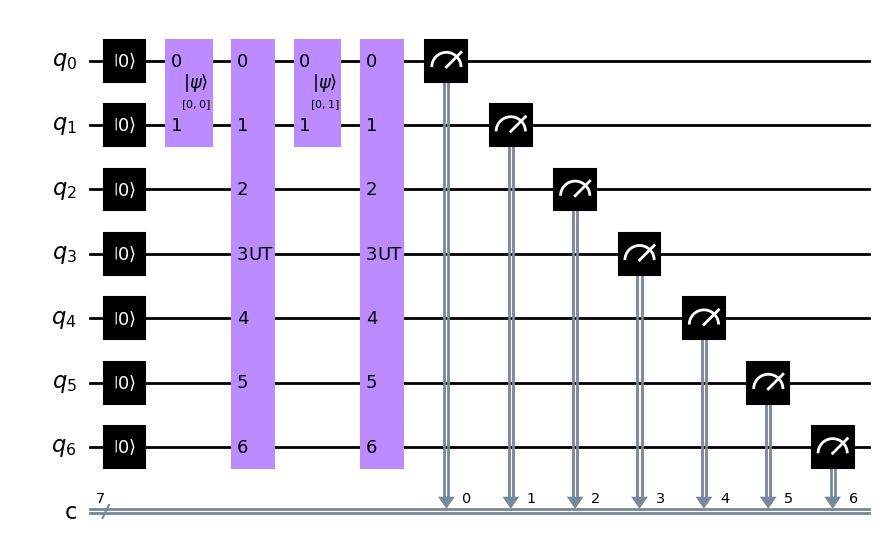

In [3]:


def build_method(circ, timestep, resop, encoder):
    # circ.measure([0, 1])
    circ.initialize(encoder[timestep], [0, 1])
    circ.unitary(resop, circ.qubits, label=resop.label)
    return circ

res = QReservoir(qubits=n_qubits, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method),
    Layers.Measurement(range(n_qubits))
], resop = UT,
 encoder = {
    0: '00',
    1: '01',
    2: '10',
    3: '11'
}, M=M)

res.circuit.draw('mpl')



In [4]:
states = res.run(timeseries, shots=SHOTS, incrementally=True)

Simulating: 100%|██████████| 280/280 [07:26<00:00,  1.60s/it]


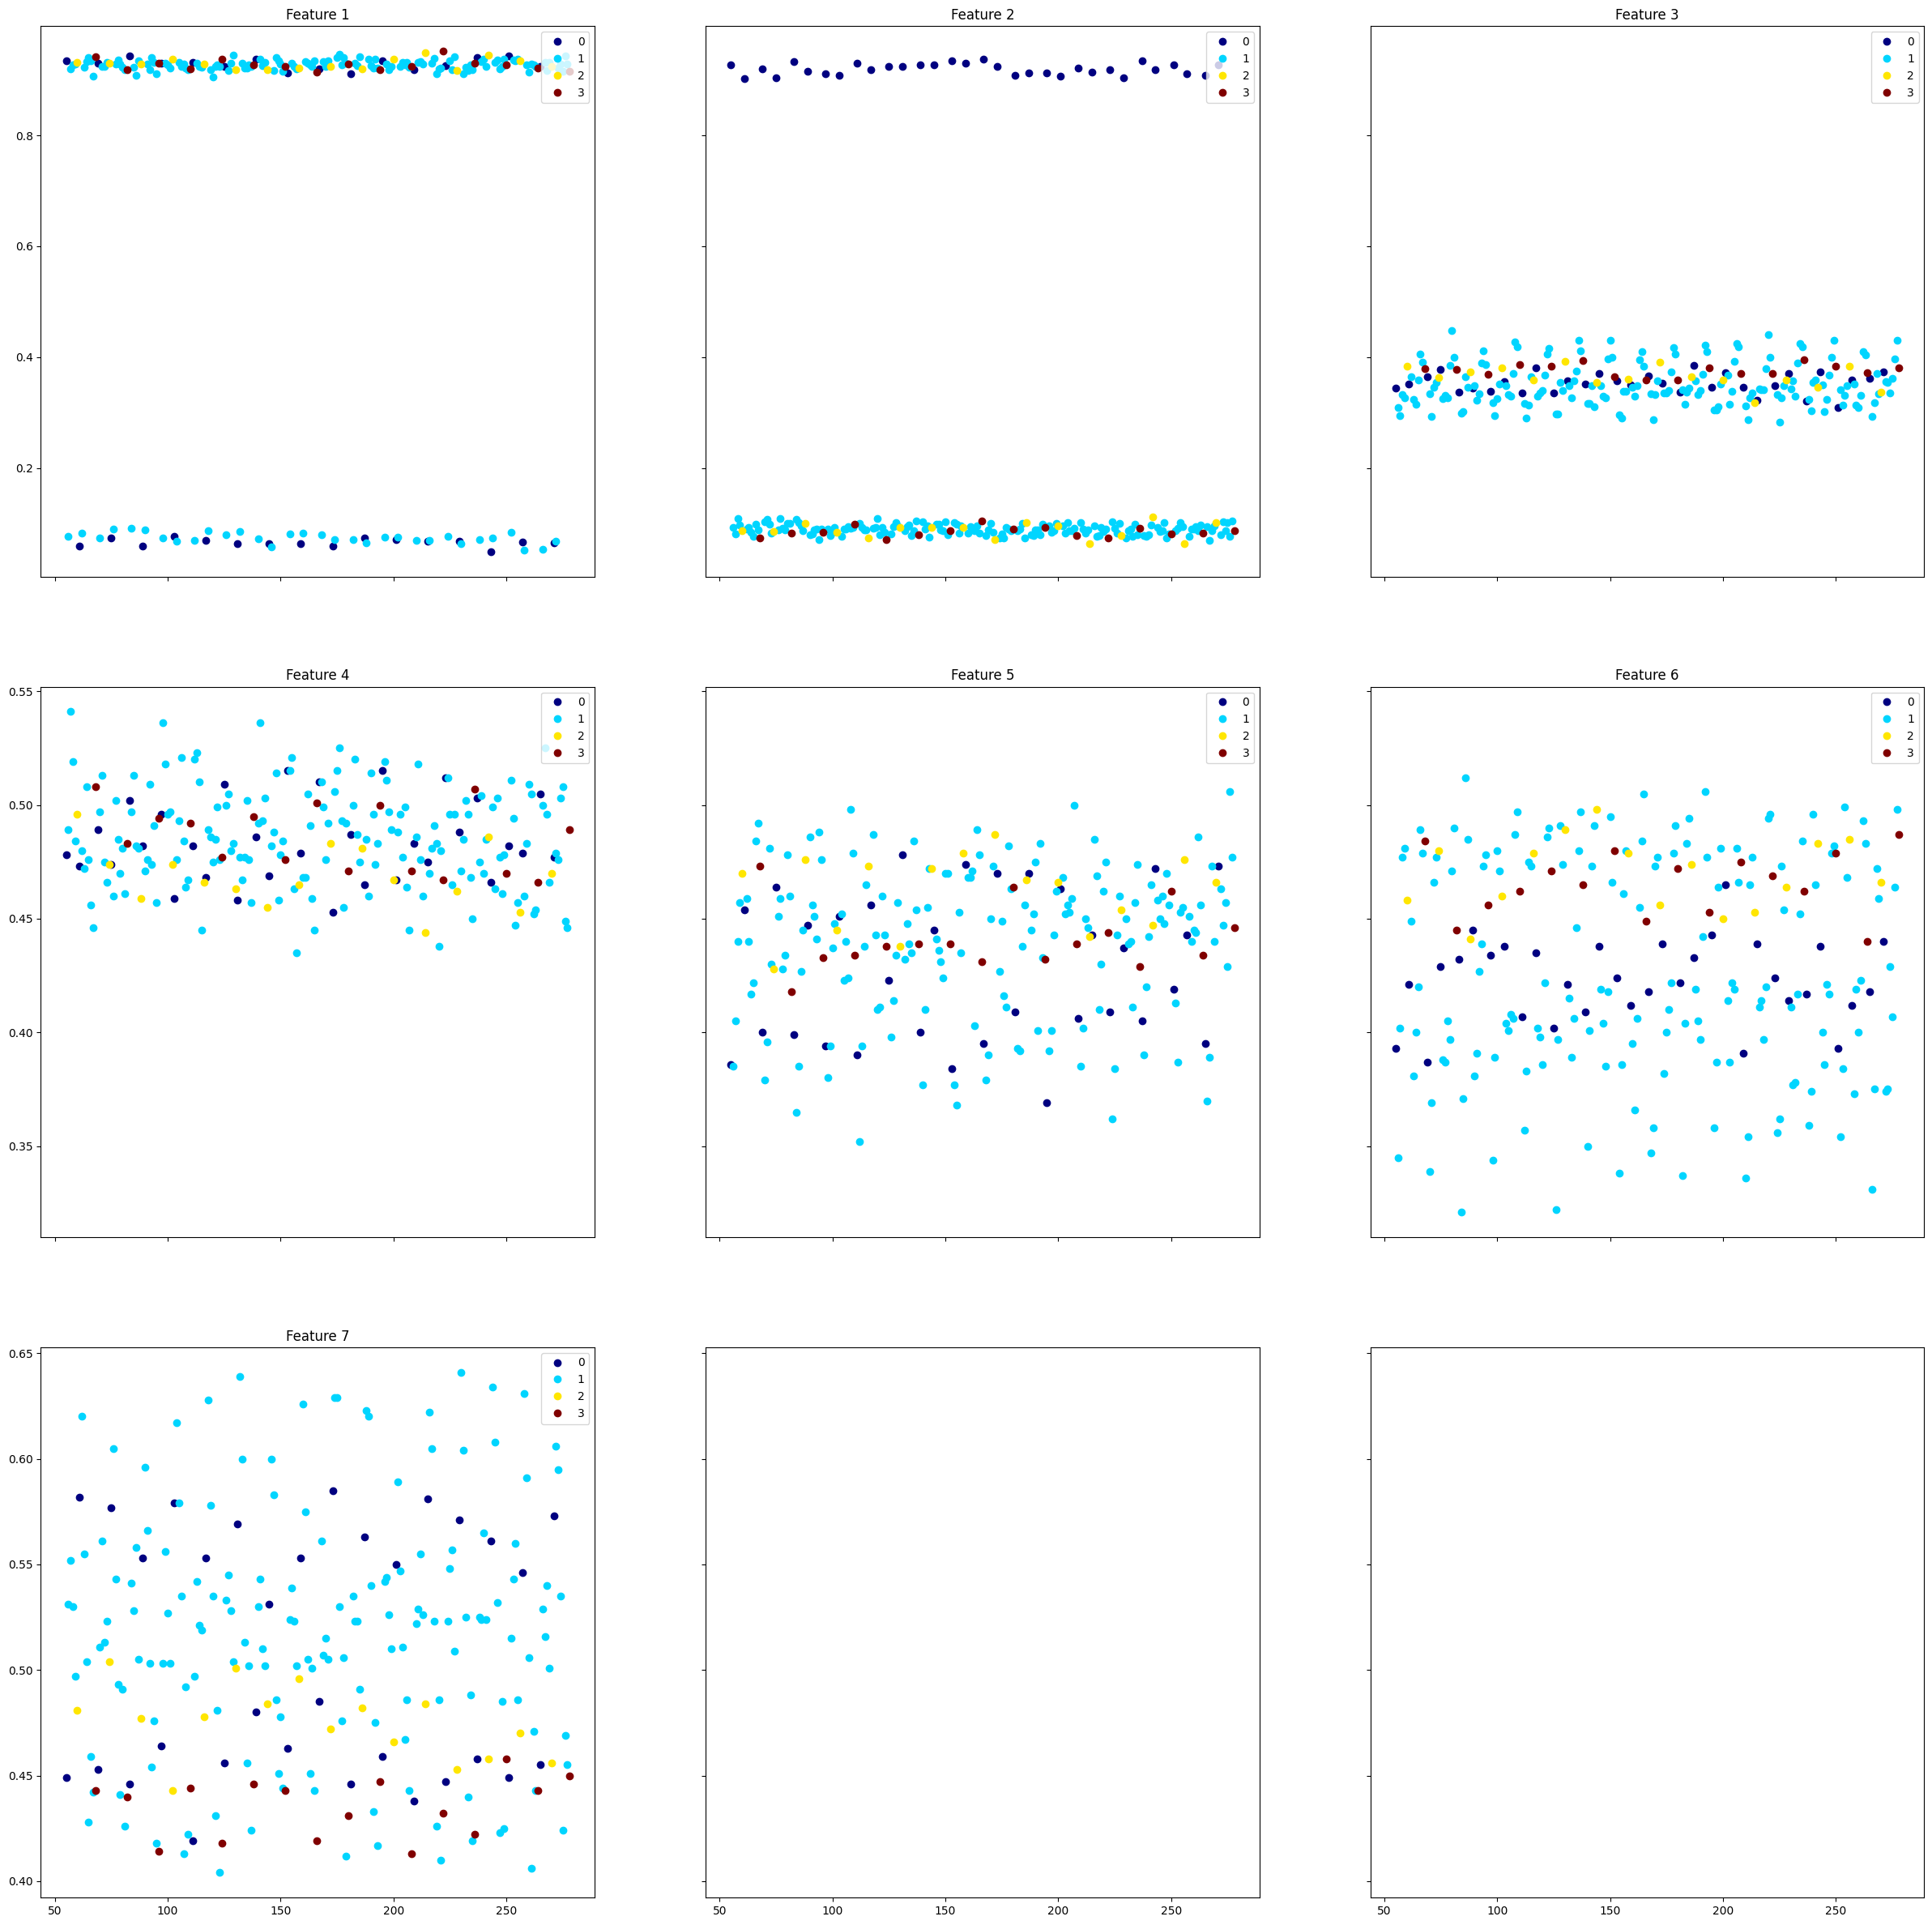

In [5]:

fig ,axes = utilities.result_plotter(states[:-1], timeseries[1:], warmup=0.2)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
WARMUP = 0.1

warmup = int(len(states) * WARMUP)

x = states[:-1][warmup:]
target = timeseries[1:][warmup:]

# print(x[:, -1])

model = make_pipeline(StandardScaler(), RidgeClassifierCV())
model.fit(x, target)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgeclassifiercv', RidgeClassifierCV())])

In [7]:

pred_states, preds = res.predict(num_pred=60, model=model, from_series=timeseries)

Predicting: 100%|██████████| 2430/2430 [09:48<00:00,  4.13it/s]


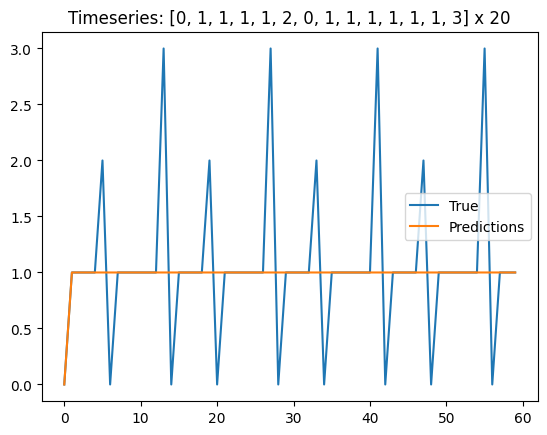

In [8]:
ans = ANSWER * len(preds)
# score = utilities.NMSE(preds[:minlen], np.array(timeseries)[:minlen])
plt.plot(ans[:len(preds)], label="True")
plt.plot(preds, label="Predictions")
plt.title(f'Timeseries: {ANSWER} x {N_T}')
plt.legend()

C:\Users\otkul\AppData\Local\Temp\ipykernel_26648\4011902952.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=cmap(i))


Text(0.5, 0, 'state 3')

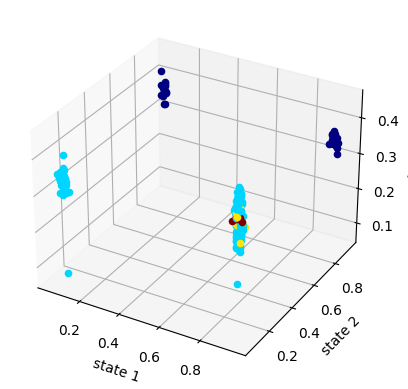

In [9]:

xx = states[:, 0][:-1]
yy = states[:, 1][:-1]
zz = states[:, 2][:-1]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
for i, x, y, z in zip(timeseries[1:], xx, yy, zz):
    ax.scatter(x, y, z, c=cmap(i))
ax.set_xlabel('state 1')
ax.set_ylabel('state 2')
ax.set_zlabel('state 3')


C:\Users\otkul\AppData\Local\Temp\ipykernel_26648\2231557806.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=cmap(i))


Text(0.5, 0, 'state 3')

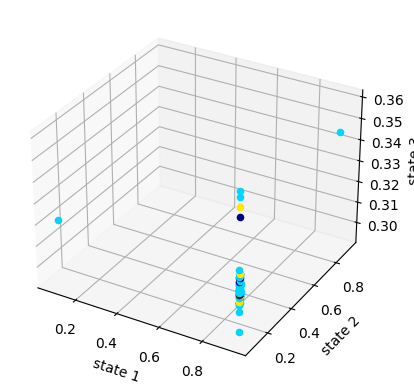

In [10]:

xx = pred_states[:, 0][:-1]
yy = pred_states[:, 1][:-1]
zz = pred_states[:, 2][:-1]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
for i, x, y, z in zip(timeseries[1:], xx, yy, zz):
    ax.scatter(x, y, z, c=cmap(i))
ax.set_xlabel('state 1')
ax.set_ylabel('state 2')
ax.set_zlabel('state 3')
